In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


from plotly import __version__
import cufflinks as cf

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
%matplotlib inline

In [3]:
plt.style.use("seaborn")

# Loading in data

In [4]:
# Import hourly pickups by Chicago Side
df_sides = pd.read_csv("hour_pickups_sides_final.csv")

df_sides["StartTime"] = pd.to_datetime(df_sides["StartTime"], 
                                       format="%d/%m/%Y %H:%M")

# set index
df_sides.set_index("StartTime", inplace=True)

df_sides.describe().astype(int)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season
count,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224
mean,88,40,32,199,218,308,68,49,22,15,0,0,1
std,46,30,16,135,126,196,36,23,11,8,0,0,1
min,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,53,16,20,101,114,138,37,31,14,9,0,0,1
50%,87,36,32,169,219,305,70,51,23,15,0,0,2
75%,117,61,43,262,298,441,96,67,31,21,0,1,2
max,306,168,121,901,738,1079,210,141,80,53,1,1,3


In [5]:
# concert dataframe to floats
df_sides.astype(float)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season
StartTime,,,,,,,,,,,,,
2018-11-01 00:00:00,70.0,15.0,20.0,174.0,134.0,141.0,48.0,25.0,17.0,12.0,0.0,0.0,2.0
2018-11-01 01:00:00,46.0,5.0,9.0,200.0,94.0,103.0,22.0,16.0,17.0,7.0,0.0,0.0,2.0
2018-11-01 02:00:00,38.0,1.0,11.0,122.0,67.0,74.0,13.0,16.0,13.0,8.0,0.0,0.0,2.0
2018-11-01 03:00:00,19.0,1.0,15.0,73.0,51.0,63.0,9.0,13.0,15.0,8.0,0.0,0.0,2.0
2018-11-01 04:00:00,27.0,0.0,12.0,50.0,50.0,49.0,18.0,22.0,13.0,6.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,253.0,30.0,79.0,600.0,491.0,637.0,109.0,69.0,32.0,31.0,1.0,0.0,3.0
2019-12-31 20:00:00,279.0,20.0,82.0,695.0,540.0,647.0,110.0,106.0,47.0,42.0,1.0,0.0,3.0
2019-12-31 21:00:00,255.0,23.0,121.0,610.0,513.0,669.0,115.0,75.0,40.0,28.0,1.0,0.0,3.0


LSTM Multivariate demand prediction with weather data.
Should add weather data to the dataset. In other words, I am making a multivariate time series.

In [6]:
# Import hourly weather data

weather = pd.read_csv("Chicago Ohare hourly weather relevant data.csv")
weather["Date"] = pd.to_datetime(weather["Date"])
weather.drop("WeatherType", axis=1, inplace=True)
weather["Temperature"] = weather["Temperature"].astype("float32")
weather.set_index("Date", inplace=True)

In [7]:
weather.head(2)

,Precipitation,WindSpeed,Temperature
Date,,,
2018-11-01 00:00:00,0.0,9.66,9.0
2018-11-01 01:00:00,0.0,9.66,9.0


In [8]:
df_sides_weather = df_sides.merge(weather, how="left", left_index=True, right_index=True)
df_sides_weather.head(3)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season,Precipitation,WindSpeed,Temperature
StartTime,,,,,,,,,,,,,,,,
2018-11-01 00:00:00,70,15,20,174,134,141,48,25,17,12,0,0,2,0.0,9.66,9.0
2018-11-01 01:00:00,46,5,9,200,94,103,22,16,17,7,0,0,2,0.0,9.66,9.0
2018-11-01 02:00:00,38,1,11,122,67,74,13,16,13,8,0,0,2,0.0,9.66,9.0


# Visualization of hourly pickups across sides

In [9]:
def visualize(data, colnumber, start_val, end_val):
    plt.figure(figsize=(10,5))
    plt.plot(data.iloc[start_val:end_val, colnumber])

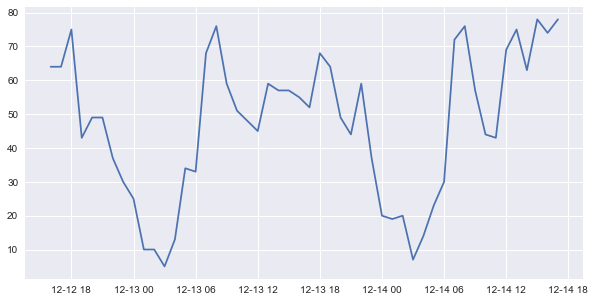

In [10]:
visualize(df_sides_weather, colnumber=7, start_val=1000, end_val=1050)

# Iterate over each column

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import ExponentialSmoothing as es
from statsmodels.tsa.api import SimpleExpSmoothing as ses
from statsmodels.tsa.api import Holt as holt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [12]:
df_sides.head(3)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season
StartTime,,,,,,,,,,,,,
2018-11-01 00:00:00,70,15,20,174,134,141,48,25,17,12,0,0,2
2018-11-01 01:00:00,46,5,9,200,94,103,22,16,17,7,0,0,2
2018-11-01 02:00:00,38,1,11,122,67,74,13,16,13,8,0,0,2


# 1st method: Holt-Winters Exponential Smoothing

Functions needed to loop through the sides:
- Split data
- define, fit, and make predictions
- Concatenate test set and predictions
- Evaluate: calculate RMSE for test data against predictions

In [13]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

def split_data_hw(data):
    train_size = int(len(data) * 0.8)
    test_size = len(data) - train_size
    
    # split data into train and test sets
    train = data[0:train_size]
    test = data[train_size:]
    
    return train, test

def define_hw(data, s_periods, test):
    # Holt-Winters Exponential Smoothing
    model = es(data, trend="add", seasonal="add", seasonal_periods=s_periods, damped=True)
    # fit model
    model_fit = model.fit()
    # make predictions
    predictions = model_fit.forecast(len(test))
    
    return model, model_fit, predictions

def hw_concat_predictions(predictions, testdata):
    # Concatenate predictions on test data with test data set and daily pickups
    HW_testpred = pd.DataFrame(predictions)
    HW_testpred.rename(columns={0: "Prediction"}, inplace=True)
    HW_testdata_pred = pd.concat([testdata, HW_testpred], axis=1)
    
    return HW_testpred, HW_testdata_pred 

def hw_evaluate(data, start_val, end_val):
    # mse
    rmse_error = rmse(data.iloc[:, 0], data.iloc[:, -1]) 
    print("RMSE Error:", rmse_error)

    # print min max values of predictions and actual values.
    print("Min. value test data:", data.iloc[:, 0].min())
    print("Max. value test data:", data.iloc[:, 0].max())

    print("Min. value predictions:", data.iloc[:, 1].min())
    print("Max. value predictions:", data.iloc[:, 1].max())
    
    # plot performance
#     fig, ax = plt.subplots(figsize=(15,5))
#     ax.plot(data.iloc[start_val:end_val, 0])
#     ax.plot(data.iloc[start_val:end_val, 1])

    return rmse_error

In [14]:
# Split data for each Side
train_dic = {}
test_dic = {}

for key in df_sides[["FNS", "Ohara", "NWS", "NS", "WS", "CEN", "SS", "SWS", "FSWS", "FSES"]]:
    train, test = split_data_hw(df_sides[key])
    train_dic[key], test_dic[key] = train, test
    
#     train_size = int(len(df_sides[key]) * 0.8)
#     test_size = len(df_sides[key]) - train_size
    
#     # split data into train and test sets
#     train = df_sides[key][0:train_size]
#     test = df_sides[key][train_size:]
#     train_dic[key] = train
#     test_dic[key] = test

In [ ]:
test_dic.keys()

In [ ]:
# Define, fit, make predictions for each side
model_dic = {}
model_fit_dic = {}
predictions_dic = {}

for key in train_dic:
    model, model_fit, predictions = define_hw(train_dic[key], 168, test_dic[key])
    model_dic[key], model_fit_dic[key], predictions_dic[key] = model, model_fit, predictions

In [ ]:
predictions_dic.keys()

In [ ]:
# concatenate test set and predictions
HW_testpred_dic = {}
HW_testdata_pred_dic = {}

for key in predictions_dic:
    HW_testpred, HW_testdata_pred = hw_concat_predictions(predictions_dic[key], test_dic[key])
    HW_testpred_dic[key], HW_testdata_pred_dic[key] = HW_testpred, HW_testdata_pred

In [ ]:
print(HW_testdata_pred_dic.keys())

In [ ]:
# evaluate: calculate RMSE for test data against predictions
rmse_error_dic = {}

for key in HW_testdata_pred_dic:
    rmse_error = hw_evaluate(HW_testdata_pred_dic[key], 1, 10)
    rmse_error_dic[key] = rmse_error

In [ ]:
rmse_error_dic["NS"]

In [ ]:
HW_testdata_pred_dic["NS"].iloc[1500:, 0].plot()
HW_testdata_pred_dic["NS"].iloc[1500:, 1].plot()

In [ ]:
train_dic["FNS"].plot()
test_dic["FNS"].plot()

In [ ]:
HW_testdata_pred_dic["FNS"].to_csv("p.csv")
HW_testdata_pred_dic["Ohara"].to_csv("1.csv")
HW_testdata_pred_dic["CEN"].to_csv("2.csv")

# 2nd method: Seasonal ARIMA

Functions needed to loop through the sides:
- Difference data
- define, fit, and make predictions
- Concatenate test set and predictions
- Inverse differencing
- Evaluate: calculate RMSE for test data against predictions

SARIMA(p, d, q)x(P, D, Q). Need to determine p, d, q, P, D, Q

# Differencing time series of each side

1st step: plot ACF and PACF plots to estimate d, and D parameters

In [ ]:
df_test = pd.DataFrame(df_sides['Ohara'])
df_test["station"] = df_test["Ohara"] - df_test["Ohara"].rolling(24).mean()
df_test.tail(3)

Data is clearly not stationary given slow decay of spiks in ACF. Need aseasonal and non-seasonal differincing. For now need SARIMA(x, 1, 1)x(x, 1, x)

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 10))
x = (df_test.station.dropna() - df_test.station.dropna().shift(168)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [ ]:
df_fns = df_sides.iloc[:,0]

In [ ]:
def get_stationarity(timeseries):
    # rolling statistics
    rolling_mean = timeseries.rolling(window=24).mean()
    rolling_std = timeseries.rolling(window=24).std()
    
    # rolling statistics plot
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(timeseries.index, timeseries, color="blue", label="Original")
    ax.plot(rolling_mean, color="red", label="Rolling Mean")
    ax.plot(rolling_std, color="black", label="Rolling Std")
    ax.legend(loc="best")
    ax.set_title("Rolling Mean & Standard Deviation")
    
    # Dickey-Fuller test:
    result = adfuller(timeseries, maxlag=24)
    print("ADF Statistics: {}".format(result[0]))
    print("p-value: {}".format(result[1]))
    print("Critical Values:")
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [ ]:
get_stationarity(diff_values) # ohara

In [ ]:
# get ACF and PACF plot
plot_acf(df_fns, alpha=0.01)
plot_pacf(df_fns, alpha=0.01)

ACF function shows slow decline of the correlation between lags, indicative that many lags can be used to forecast future events, but this is just the nature of non-stationary series.

PCF shows indirect correlation by removing the effect of preceding lags. Only the first two lags are useful. 

When differncing the time series, there is only a significant correlation in the first 3 lags with the first lag being a strong predictor.

In [15]:
# select Side
df_fns = df_sides.iloc[:,5]

# difference and split data
train_fns, test_fns = split_data_hw(df_fns)
diff_values = pd.DataFrame(difference(df_fns, 1))
print(diff_values.shape)

train_fns_diff, test_fns_diff = split_data_hw(diff_values)

(10223, 1)


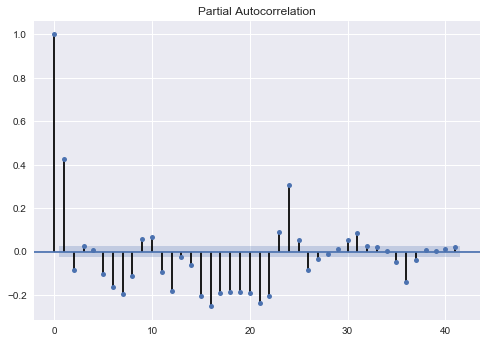

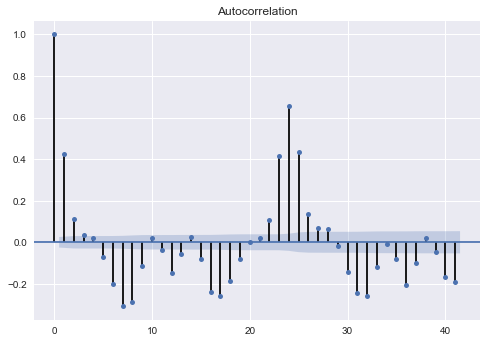

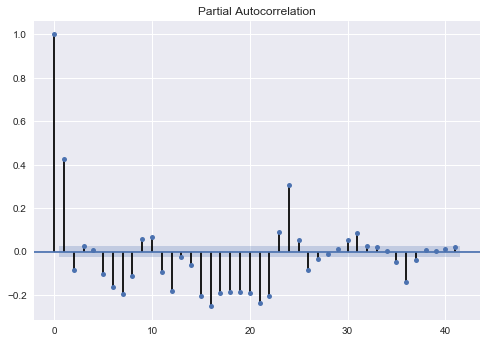

In [16]:
# get ACF and PACF plot
plot_acf(diff_values, alpha=0.01)
plot_pacf(diff_values, alpha=0.01)

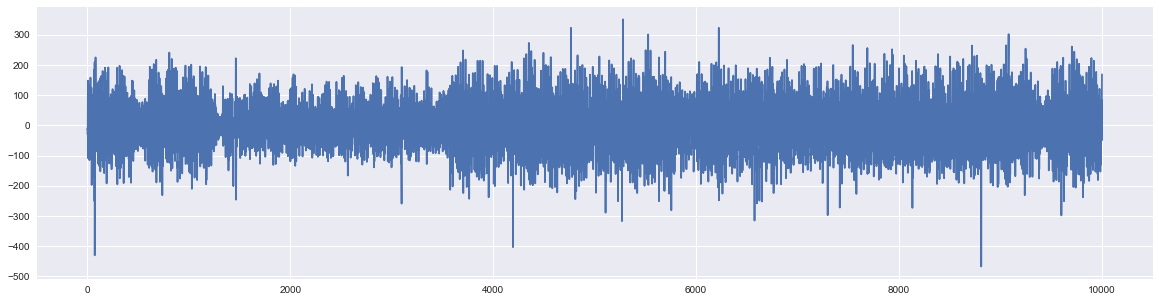

In [17]:
diff_values.iloc[1:10000, 0].plot(figsize=(20,5))

# ARIMA: auto arima

In [18]:
# define model
stepwise_model = auto_arima(train_fns_diff, m=168, 
                            start_p=0, max_d=2, start_q=0,
                            max_p=3, max_q=3, start_P=0,
                            start_Q=0, max_D=1, max_P=2,
                            max_Q=2, trace=True, seasonal=False, 
                            error_action="ignore", suppress_warnings=True, stepwise=True)


Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=94370.554, BIC=94384.573, Time=0.274 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=92864.186, BIC=92885.213, Time=0.286 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=92880.771, BIC=92901.798, Time=0.936 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=94368.557, BIC=94375.566, Time=0.073 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=92805.878, BIC=92833.915, Time=0.395 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=92800.305, BIC=92835.351, Time=0.514 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=92802.296, BIC=92844.351, Time=2.681 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=92802.734, BIC=92837.780, Time=1.291 seconds
Total fit time: 6.460 seconds


In [19]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8178
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -46395.152
Date:                Fri, 26 Jun 2020   AIC                          92800.305
Time:                        19:55:20   BIC                          92835.351
Sample:                             0   HQIC                         92812.287
                               - 8178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0344      0.859      0.040      0.968      -1.649       1.717
ar.L1          0.4482      0.009     48.721      0.000       0.430       0.466
ar.L2         -0.0993      0.010     -9.709      0.000      -0.119      -0.079
ar.L3          0.0304      0.011      2.761      0.006       0.009       0.052
sigma2      4958.0272     60.100     82.496      0.000    4840.233    5075.821
===================================================================================
Ljung-Box (Q):                     5055.05   Jarque-Bera (JB):              1325.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# forecast
n_test = len(test_fns)
test_predictions = stepwise_model.predict(n_test)
print(len(test_predictions))

# invert predictions
inverted_ytest = list()
for i in range(len(test_predictions)):
    value = inverse_difference(df_fns, test_predictions[i], len(test_predictions)+1-i) # 10224, 2045, 2045+1-i
    inverted_ytest.append(value)
inverted_ytest = pd.DataFrame(inverted_ytest)
inverted_ytest

# concat predictions
testdata_pred = pd.concat([test_fns.reset_index().iloc[:,1:], inverted_ytest], axis=1)

sarima_testpred = pd.DataFrame(inverted_ytest)
sarima_testpred.rename(columns={0: "Prediction"}, inplace=True)
sarima_testdata_pred = pd.concat([test_dic["CEN"].reset_index().iloc[:,1:], sarima_testpred], axis=1)


2045


In [21]:
sarima_testdata_pred

,CEN,Prediction
0,504,511.865591
1,424,501.900589
2,345,424.756456
3,276,345.090783
4,147,275.936034
...,...,...
2040,637,496.055363
2041,647,637.055363
2042,669,647.055363
2043,525,669.055363


In [23]:
rmse_error = rmse(sarima_testdata_pred.iloc[1:, 0], sarima_testdata_pred.iloc[1:, -1]) 
rmse_error

86.27615204487256

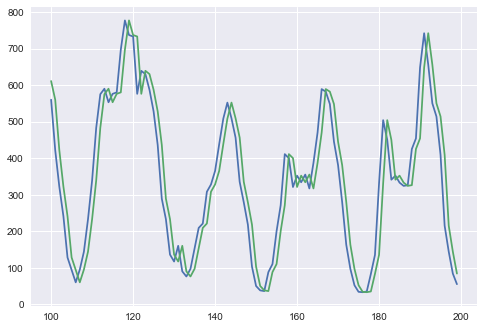

In [24]:
sarima_testdata_pred.iloc[100:200, 0].plot()
sarima_testdata_pred.iloc[100:200, 1].plot()

# ARIMA: SARIMAX

In [ ]:
my_order = (1,0,0)
my_seasonal_order = (0,1,1,24)

model = SARIMAX(train_fns_diff, 
                order=my_order, trend="c",
                seasonal_order=my_seasonal_order, 
                enforce_stationarity=True,
                enforce_invertibility=True).fit()

In [ ]:
# forecast
n_test = len(test_fns)
test_predictions = model.forecast(n_test)
test_predictions

In [ ]:
# invert predictions
inverted_ytest = list()
for i in range(len(test_predictions)):
    value = test_predictions.iloc[i] + df_fns.iloc[-(len(test_predictions)+1-i)]
    inverted_ytest.append(value)
inverted_ytest = pd.DataFrame(inverted_ytest)

# inverse_difference(df_fns, test_predictions[i], len(test_predictions)+1-i) # 10224, 2045, 2045+1-i
inverted_ytest

In [ ]:
sarima_testpred = pd.DataFrame(inverted_ytest)
sarima_testpred.rename(columns={0: "Prediction"}, inplace=True)
sarima_testdata_pred = pd.concat([test_dic["FNS"].reset_index().iloc[:,1:], sarima_testpred], axis=1)
sarima_testdata_pred

In [ ]:
rmse_error = rmse(sarima_testdata_pred.iloc[1:, 0], sarima_testdata_pred.iloc[1:, -1]) 
rmse_error

In [ ]:
sarima_testdata_pred.iloc[1500:-1, 0].plot(figsize=(15,8))
sarima_testdata_pred.iloc[1500:-1, 1].plot(figsize=(15,8))

In [ ]:
# Define, fit, make predictions for each side
model_dic = {}
test_predictions_dic = {}

for key in train_dic:
    model, test_predictions = define_sarima(train_dic[key], my_order, my_seasonal_order, test_dic[key])
    model_dic[key], test_predictions_dic[key] = model, test_predictions
    
    

In [ ]:
# concatenate test set and predictions
sarima_testpred_dic = {}
sarima_testdata_pred_dic = {}

for key in test_predictions_dic:
    sarima_testpred, sarima_testdata_pred = sarima_concatenate_predictions(test_predictions_dic[key], test_dic[key])
    sarima_testpred_dic[key], sarima_testdata_pred[key] = sarima_testpred, sarima_testdata_pred


In [ ]:
# evaluate: calculate RMSE for test data against predictions
rmse_error_dic = {}

for key in sarima_testdata_pred_dic:
    rmse_error = sarima_evaluate(sarima_testdata_pred[key], 1, 10)
    rmse_error_dic = rmse_error


# 3rd method: Prophet

In [ ]:
# creating a new df for prophet test

df_test = df_sides["CEN"]
df_test["ds"] = df_test.index
df_test["y"] = df_test["CEN"]
df_test.reset_index(inplace=True)

In [ ]:
# fitting df to prophet

model = Prohet(seasonality=True)
model.fit(df_test)

In [ ]:
future = model.make_future_dataframe(periodes=X, freq="H")

# predict method assigns to each row a predicted value named yhat.
# also has yhat_lower and yhat_upper as confidence intervals.
forecast = model.predict(future)

In [ ]:
# forecasting
model.plot(forecast, xlabel="Date", ylabel="Hourly pickups")
plt.title('Prophet - Model fit and 1-month prediction')


In [ ]:
model.plot_components(forecast);

In [ ]:
# scoring
predictions = pd.DataFrame(forecast.yhat[-720:])
plot_forecast(test["columnname"], predictions)
rmse(ts15_test["columnname"], predictions)